In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import *

In [3]:
!pwd

/home/jupyter/Age Detection Challenge/Age-Detection-of-Indian-Actors


### Loading the data

The following `fast.ai` function:
- loads the data from the specified folder
- gets the labels from the accompanying .csv file
- apply all the transformations for data augmentation
- prepares the validation set
- resizes the images to (64,64)
- prepares a mini-batch of 32 for training

Wuh! That was neat! 

In [9]:
path = '/home/jupyter/Age Detection Challenge/Age-Detection-of-Indian-Actors/Train'
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(flip_vert=True), valid_pct=0.2, csv_labels='train.csv',
                                   size=(64), bs=32).normalize(imagenet_stats)

### Looking at the data in the right way

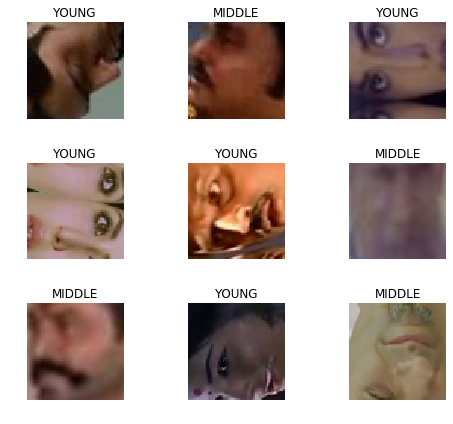

In [10]:
data.show_batch(rows=3, figsize=(7,6))

In [16]:
print(data.classes)
len(data.classes),data.c

['MIDDLE', 'OLD', 'YOUNG']


(3, 3)

### Start of modeling with a pre-trained ResNet50

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Leslie Smith's learning rate finder technique as discussed in: https://arxiv.org/abs/1506.01186 (incoporated in a library)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


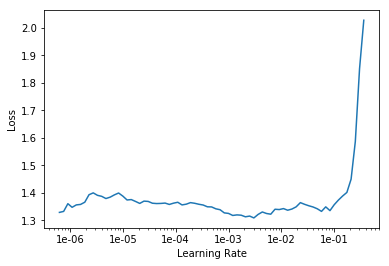

In [12]:
learn.lr_find()
learn.recorder.plot()

### Training for 10 epochs using the one cycle policy introduced by Leslie Smith

In [13]:
learn.fit_one_cycle(10)

### Saving the model for later use

In [14]:
learn.save('stage-1-rn50')

### Getting to know where our model is getting confused the most

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

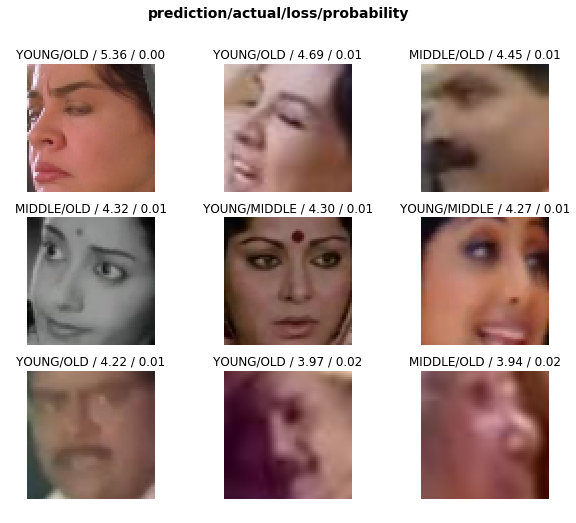

In [19]:
interp.plot_top_losses(9, figsize=(10,8))

> There are some bad noise in the dataset. Take a look at the sixth picture of the above plot. According to the data given, the age of the person in that picture is **OLD**. Is it really true? So, this type of noises are causing the model to get confused. So, better remove them from the training and see the validation (we will do this later). 

### A bit more model training with 5 epochs and differential learning rates (`max_lr`)

In [20]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-5/5))

### Combining the earlier model weights plus this one

In [ ]:
learn.load('stage-1-rn50')

In [22]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-5/5))

We are improving. Why not more improvement? Let's go for 20 epochs this time. 

In [23]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-5,1e-5/5))

We have a good improvement. Let's save the model weights.

In [24]:
learn.save('stage-2-rn50')

### Experimenting with other learning rate ranges (and failing)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-2,1e-2/5))

![](https://i.ibb.co/chw3hkb/Capture.png)

### Combining the latest decent model weights + a bit more training

In [26]:
learn.load('stage-2-rn50')
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-5/5))

A clear bump in the accuracy. Let's save the weights. We will use it for our initial predicition. 

In [28]:
learn.save('stage-3-rn50')